### **PRF applied to the SkyMapper 4 dataset**
I tried to keep hings as close as possible to the original analysis, including how we identify extended objects!

**Keep in mind: I will only use oversampling! Synth data will come back in the future, when the torus is refined and a better model is available**

In [1]:
# Base, we go nowhere without numpy
import numpy as np

# Plot
import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    precision_recall_fscore_support,
)

from pathlib import Path

# Random
import pickle
from tqdm import tqdm
from copy import deepcopy as dc

# Machine learning
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from PRF import prf


from datetime import datetime

# Remove exponential/decimal? Boh!
np.set_printoptions(suppress=True)

In [2]:
run_again = True
timestamp = datetime.today().strftime("%Y-%m-%d")

print(f"Current timestamp: {timestamp}")
QSO_redshift_threshold = 2.5

Current timestamp: 2025-02-25


In [3]:
def gen_labels(labels):
    """
    Generates labels given a list. Ex:
    gen_labels([1, 2, 3]) -> ['0 - 1', '1 - 2', '2 - 3', '3 - ']
    """
    r = []
    for n, e in enumerate(labels):
        if n == 0:
            r.append("0 - {}".format(e))
        else:
            r.append("{} - {}".format(labels[n - 1], labels[n]))
    r.append("{} - ".format(labels[-1]))
    return r


def get_y(z, th=QSO_redshift_threshold):
    return 0 if z <= th else 1


def get_splitting_y(z, thresholds):
    th_sorted = np.sort(thresholds)[::-1]
    n_labels = len(thresholds)
    for n, th in enumerate(th_sorted):
        if z >= th:
            return n_labels - n
    else:
        return 0


def save_obj(obj, name):
    with open(
        Path("/Users/francesco/uvp/PRF/data/PRF_out") / (name + ".pkl"), "wb"
    ) as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(
        Path("/Users/francesco/uvp/PRF/data/PRF_out") / (name + ".pkl"), "rb"
    ) as f:
        return pickle.load(f)

In [4]:
# Start loading data
basepath = Path("/Users/francesco/uvp/PRF/data/MS4")

# this is what actually is used in the selection, but metadata
#  are needed here!
meta = np.load(basepath / "meta_2025-02-20_13:31:18.npy")

# Should really save in a way that preserves the original data type
# Order saved from Julia as of 2025-02-20
#
# names_meta = [
#     "_id",
#     "qid",
#     "raj2000",
#     "dej2000",
#     "otypeid",
#     "z_spec",
#     "parallax_over_error",
#     "pmra_over_error",
#     "pmdec_over_error",
#     "sigma_ext",
# ]

qid = meta[:, 0].astype(
    int
)  # using this instead of qid as in the new catalogue not every object has a qid
# qid = meta[:, 1].astype(int) -> Useless for the new DB
ra = meta[:, 2]
dec = meta[:, 3]
otid = meta[:, 4].astype(int)  # Otypeid, from the DataBase
z = meta[:, 5]

# this is to remove objects that do not have errors on i from the TRAINING
#  they are kept in the unknown for completeness
_mags = np.load(basepath / "mag_2025-02-20_13:31:18.npy")
_merr = np.load(basepath / "err_2025-02-20_13:31:18.npy")

# np.isfinite(_mags[:, 4]) is technically not needed
_inds_to_keep_from_beginning = np.where(
    (otid == 0) | ((otid != 0) & np.isfinite(_mags[:, 4]) & np.isfinite(_merr[:, 4]))
)[0]
_inds_to_discard_from_beginning = np.where(
    ((otid != 0) & np.isfinite(_mags[:, 4]) & np.isnan(_merr[:, 4]))
)[0]
_inds_to_discard_from_beginning_qso = np.where(
    ((otid == 1) & np.isfinite(_mags[:, 4]) & np.isnan(_merr[:, 4]))
)[0]
print(
    f"Discarding {_inds_to_discard_from_beginning.size} objects from the beginning due to missing error in i_magnitude"
)
print(
    f"There are {_inds_to_discard_from_beginning_qso.size} QSO among them, "
    f"between redsfift {z[_inds_to_discard_from_beginning_qso].min():.2f} and {z[_inds_to_discard_from_beginning_qso].max():.2f} "
    f"and median redshift of {np.median(z[_inds_to_discard_from_beginning_qso]):.2f}."
)

# only keep objects we are interested in and regenerate meta to be consistent
dm = np.load(basepath / "col_mag_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]
de = np.load(basepath / "col_err_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]
flag = np.load(basepath / "col_flag_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]
meta = np.load(basepath / "meta_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]

qid = meta[:, 0].astype(int)
# using this, aka _id, instead of qid as in the new catalogue not every object has a qid
#  still calling it in the same way to avoid changing the rest of the code

# qid = meta[:, 1].astype(int) -> Useless for the new DB

ra = meta[:, 2]
dec = meta[:, 3]
otid = meta[:, 4].astype(int)  # Otypeid, from the DataBase
z = meta[:, 5]

Discarding 27837 objects from the beginning due to missing error in i_magnitude
There are 25 QSO among them, between redsfift 0.26 and 3.04 and median redshift of 1.50.


### **QSO vs everything else**
We start from scratch, so we first have to find QSO candidates.
Before enything, test on a known dataset to make sure everything is still working. I'll use the flower one from SkLearn

In [5]:
from sklearn import datasets

iris = datasets.load_iris()
X_iris = (
    iris.data
)  # don't really care about errors in this case, or flags for that matter
y_iris = iris.target

In [6]:
# Don't really care about splitting either to be honest, I am just checking that everything works the way it's supposed to
prf_iris = prf(n_estimators=100, bootstrap=True, keep_proba=0.05, max_depth=15)

prf_iris.fit(X=X_iris, y=y_iris)

prf_proba = prf_iris.predict_proba(X=X_iris)
prf_class = prf_iris.predict(X=X_iris)

100%|██████████| 100/100 [00:03<00:00, 29.74it/s]
100it [00:00, 138.36it/s]
100it [00:00, 10132.64it/s]


In [7]:
# try to figure out why the PRF is so slooooooww
%load_ext line_profiler


Test against the IRIS dataset!


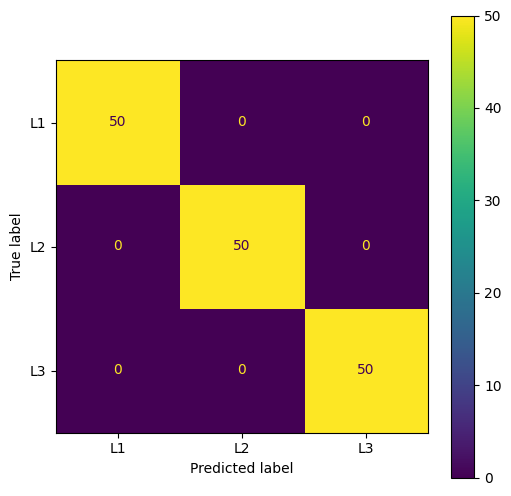

In [8]:
print("Test against the IRIS dataset!")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cm = confusion_matrix(y_iris, prf_class)
ls = ["L1", "L2", "L3"]  # your y labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot(ax=ax);

In [9]:
# Things seem to work ok, so we move to the real thing.
# Start by searching for all QSOs

# Fix RNG so we know what we are dealing with
rng = np.random.default_rng()

# Returns a subsample of a given class, based on a reference color or magnitude
#  ref: reference magnitude or color
#  ref_c: list of otypeif for all objects
#  n_bins: number of bins use to sample the available color range
#  c: undersampled class
#  n_per_bin: number of objects to keep, in each bin
#  plot: plot the output distribution
# Objects are chosen at random


def sampleClass(ref, ref_c, n_bins, c, n_per_bin=30, plot=False):
    ref_inds = np.where(ref_c == c)[0]
    current_ref = ref[ref_inds]

    out = np.array([])

    low_lim = np.nanmin(current_ref)
    hig_lim = np.nanmax(current_ref)
    delta = (hig_lim - low_lim) / n_bins

    for b in range(n_bins):
        idxs = np.where(
            (current_ref >= (low_lim + b * delta))
            & (current_ref <= (low_lim + (b + 1) * delta))
        )[0]
        if len(idxs) < n_per_bin:
            out = np.concatenate((out, ref_inds[idxs]))
        else:
            out = np.concatenate(
                (out, rng.choice(ref_inds[idxs], n_per_bin, replace=False))
            )

    if plot:
        print(
            "Total number of class {}: {}\nChosen: {}".format(
                c, len(ref_inds), len(out)
            )
        )
        fig, ax = plt.subplots(1, 1)
        ax.hist(
            (ref[out.astype(int)], current_ref),
            range=[low_lim, hig_lim],
            bins=n_bins,
            stacked=False,
            density=True,
        )

    return out.astype(int)


# Use dm[:, 7] as reference magnitude, as it's the only one with no issues with NaNs
chosen_star_idx = sampleClass(dm[:, 7], otid, 30, 5, n_per_bin=400)
chosen_gal_idx = sampleClass(dm[:, 7], otid, 30, 4, n_per_bin=350)

In [10]:
# Use the indexes to actually sample everything

star_dm = dm[chosen_star_idx, :]
star_de = de[chosen_star_idx, :]
star_flag = flag[chosen_star_idx, :]

gal_dm = dm[chosen_gal_idx, :]
gal_de = de[chosen_gal_idx, :]
gal_flag = flag[chosen_gal_idx, :]

# Metadata for stars and galaxies
star_qid = qid[chosen_star_idx]
star_ra = ra[chosen_star_idx]
star_dec = dec[chosen_star_idx]
star_otid = otid[chosen_star_idx]
star_z = z[chosen_star_idx]
gal_qid = qid[chosen_gal_idx]
gal_ra = ra[chosen_gal_idx]
gal_dec = dec[chosen_gal_idx]
gal_otid = otid[chosen_gal_idx]
gal_z = z[chosen_gal_idx]

In [11]:
# Find all QSOs
qso_idx = np.where(((otid == 1) | (otid == 2) | (otid == 3)) & (z > 0.5))[
    0
]  # Keep all kind of QSO into the sample
# Exclude low z QSO for now! They are dealt with below

qso_dm = dm[qso_idx, :]
qso_de = de[qso_idx, :]
qso_flag = flag[qso_idx, :]

qso_qid = qid[qso_idx]
qso_ra = ra[qso_idx]
qso_dec = dec[qso_idx]
qso_otid = otid[qso_idx]
qso_z = z[qso_idx]
# Find all QSOs at high z (for now keep threshold at 2.5
hz_qso_idx = np.where(
    ((otid == 1) | (otid == 2) | (otid == 3)) & (z >= QSO_redshift_threshold)
)[0]  # High z QSO

hz_qso_dm = dm[hz_qso_idx, :]
hz_qso_de = de[hz_qso_idx, :]
hz_qso_flag = flag[hz_qso_idx, :]

hz_qso_qid = qid[hz_qso_idx]
hz_qso_ra = ra[hz_qso_idx]
hz_qso_dec = dec[hz_qso_idx]
hz_qso_otid = otid[hz_qso_idx]
hz_qso_z = z[hz_qso_idx];

Currentely have 1065 QSO with z > 2.5, 454 with z > 3.0, 158 with z > 3.5 and 45 with z > 4.0


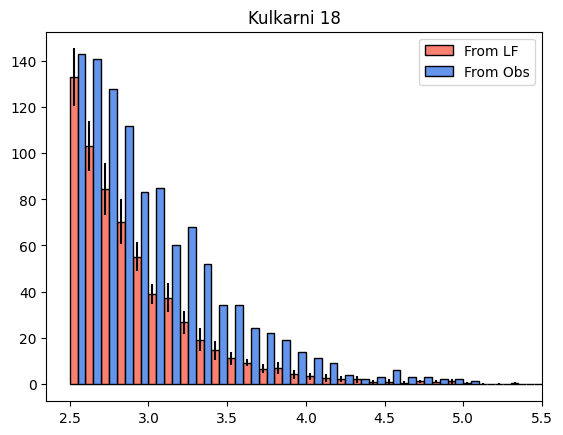

In [12]:
# How many QSOs? How are they distributed in redshift?
#  How do they compare to the current LF?
print(
    "Currentely have {} QSO with z > 2.5, {} with z > 3.0, {} with z > 3.5 and {} with z > 4.0".format(
        len(hz_qso_z),
        len(hz_qso_z[hz_qso_z > 3.0]),
        len(hz_qso_z[hz_qso_z > 3.5]),
        len(hz_qso_z[hz_qso_z > 4.0]),
    )
)

scale_factor = 1  # 14000/13000

expected_qso = np.loadtxt(
    "/Users/francesco/uvp/PRF/data/misc/MCQSO_resu_fg01.dat", skiprows=1
)
expected_qso[:, 2] = expected_qso[:, 2] * scale_factor
expected_qso[:, 3] = expected_qso[:, 3] * scale_factor

fig, ax = plt.subplots(1, 1)
known_qso_hz_hist = ax.hist(hz_qso_z, range=[2.5, 7], bins=45, color=None)
plt.close(fig)

fig, ax = plt.subplots(1, 1)

ax.set_title("Kulkarni 18")
ax.bar(
    expected_qso[expected_qso[:, 0] >= 2.5, 0],
    expected_qso[expected_qso[:, 0] >= 2.5, 2],
    align="edge",
    width=0.05,
    color="salmon",
    edgecolor="black",
    label="From LF",
)

ax.errorbar(
    expected_qso[expected_qso[:, 0] >= 2.5, 0] + 0.025,
    expected_qso[expected_qso[:, 0] >= 2.5, 2],
    expected_qso[expected_qso[:, 0] >= 2.5, 3],
    color="black",
    ls="none",
)

ax.bar(
    known_qso_hz_hist[1][:-1] + 0.05,
    known_qso_hz_hist[0],
    align="edge",
    width=0.05,
    color="cornflowerblue",
    edgecolor="black",
    label="From Obs",
)

ax.set_xlim([2.35, 5.5])
ax.legend();

Text(0, 0.5, 'Counts')

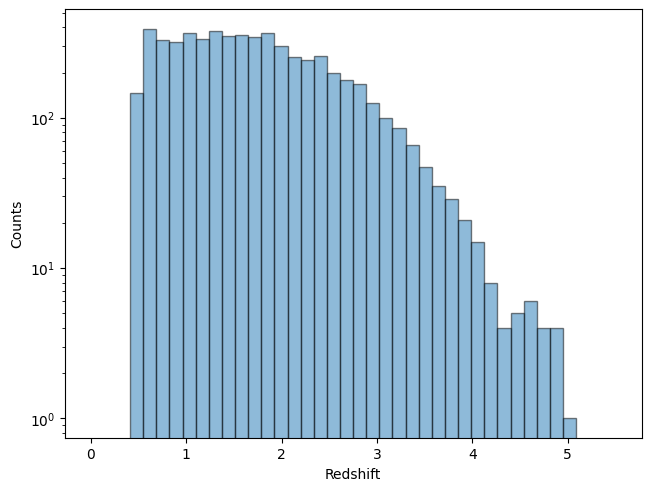

In [13]:
fig, ax = plt.subplots(1, 1, layout="constrained")
ax.hist(
    z[qso_idx], bins=40, range=[0, 5.5], alpha=0.5, label="All QSO", edgecolor="black"
)

ax.set_yscale("log")
ax.set_xlabel("Redshift")
ax.set_ylabel("Counts")

From plot above we have way to many objects at low redshift  
We sample again randomly and by colour

Text(0, 0.5, 'Counts')

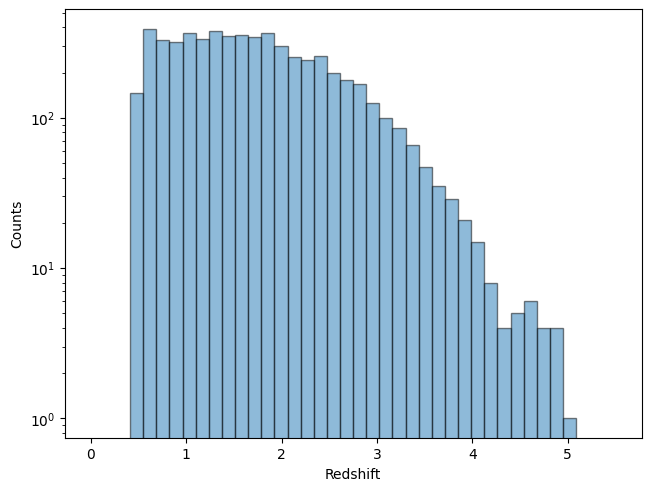

In [14]:
# Findall all objects with redshift lower than 0.5
# Split in two to avoid a hole around 0.25 - 0.5 - colors seem to be very different!
lz_qso_idx_1 = np.where(((otid == 1) | (otid == 2) | (otid == 3)) & (z <= 0.25))[0]
lz_qso_idx_2 = np.where(
    ((otid == 1) | (otid == 2) | (otid == 3)) & (z > 0.25) & (z <= 0.5)
)[0]

# for now copy otypeid and call these in a different way
tmp_otid = dc(otid)
tmp_otid[lz_qso_idx_1] = -1
tmp_otid[lz_qso_idx_2] = -2

# Redo the same thing as before, and get a subsample of the QSO with low z
chosen_lz_qso_idx_1 = sampleClass(dm[:, 7], tmp_otid, 30, -1, n_per_bin=20, plot=False)
chosen_lz_qso_idx_2 = sampleClass(dm[:, 7], tmp_otid, 30, -2, n_per_bin=35, plot=False)

chosen_lz_qso_idx = np.concatenate((chosen_lz_qso_idx_1, chosen_lz_qso_idx_2))

# Delete tmp things so that I don't have clutter around
# del(tmp_otid)

# Now that I have idx, get low-z QSO
lz_qso_dm = dm[chosen_lz_qso_idx, :]
lz_qso_de = de[chosen_lz_qso_idx, :]
lz_qso_flag = flag[chosen_lz_qso_idx, :]

# Metadata for low-z QSO
lz_qso_qid = qid[chosen_lz_qso_idx]
lz_qso_ra = ra[chosen_lz_qso_idx]
lz_qso_dec = dec[chosen_lz_qso_idx]
lz_qso_otid = otid[chosen_lz_qso_idx]
lz_qso_z = z[chosen_lz_qso_idx]

# Join again with QSO, and check the distribution is ok
qso_dm = np.vstack((qso_dm, lz_qso_dm))
qso_de = np.vstack((qso_de, lz_qso_de))
qso_flag = np.vstack((qso_flag, lz_qso_flag))

qso_qid = np.concatenate((qso_qid, lz_qso_qid))
qso_ra = np.concatenate((qso_ra, lz_qso_ra))
qso_dec = np.concatenate((qso_dec, lz_qso_dec))
qso_otid = np.concatenate((qso_otid, lz_qso_otid))
qso_z = np.concatenate((qso_z, lz_qso_z))

fig, ax = plt.subplots(1, 1, layout="constrained")
ax.hist(
    z[qso_idx], bins=40, range=[0, 5.5], alpha=0.5, label="All QSO", edgecolor="black"
)

ax.set_yscale("log")
ax.set_xlabel("Redshift")
ax.set_ylabel("Counts")

In [15]:
# Join everything together

combined_X = np.vstack((qso_dm, star_dm, gal_dm))
combined_dX = np.vstack((qso_de, star_de, gal_de))
combined_flag = np.vstack((qso_flag, star_flag, gal_flag))

combined_qid = np.concatenate((qso_qid, star_qid, gal_qid))
combined_ra = np.concatenate((qso_ra, star_ra, gal_ra))
combined_dec = np.concatenate((qso_dec, star_dec, gal_dec))
combined_otid = np.concatenate((qso_otid, star_otid, gal_otid))
combined_z = np.concatenate((qso_z, star_z, gal_z))
combined_y = np.concatenate(
    (np.zeros(qso_qid.shape), np.ones(star_qid.shape), np.ones(gal_qid.shape) * 2)
)

print(f"Total number of training objects: {combined_X.shape[0]}")
print(f"\tNumber of QSOs: {qso_dm.shape[0]}")
print(f"\tNumber of stars: {star_dm.shape[0]}")
print(f"\tNumber of galaxies: {gal_dm.shape[0]}")

Total number of training objects: 21012
	Number of QSOs: 6553
	Number of stars: 9536
	Number of galaxies: 4923


In [16]:
# Set random state
rs = 42

# Split data for train and test
# I will define a separate class for high redshift QSOs, so that I can see how well we are doing in this regard
splitting_y = dc(combined_y)

splitting_y[
    combined_z > 2.5
] = -1  # Redshift is sufficient, only QSOs have this redshit
splitting_y[combined_z > 3.0] = -2

# Split everything intro train and test
# I will drop the combined_ into the name, train and test will make it clear that I am not using the combined, general thing
train_X, test_X = train_test_split(
    combined_X, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_dX, test_dX = train_test_split(
    combined_dX, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_flag, test_flag = train_test_split(
    combined_flag, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_y, test_y = train_test_split(
    combined_y, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_qid, test_qid = train_test_split(
    combined_qid, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_ra, test_ra = train_test_split(
    combined_ra, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_dec, test_dec = train_test_split(
    combined_dec, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_otid, test_otid = train_test_split(
    combined_otid, test_size=0.25, random_state=rs, stratify=splitting_y
)
train_z, test_z = train_test_split(
    combined_z, test_size=0.25, random_state=rs, stratify=splitting_y
)

train_data = (train_X, train_dX, train_y, train_flag)

In [17]:
# Thanks: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
# Write down the function for oversampling data. I will need this, most likely, for low and high redshift classifications
from sklearn.model_selection import StratifiedKFold


def score_model(
    model,
    params,
    data=train_data,
    data_names=["X", "dX", "y", "flags"],
    cv=None,
    rs_kfold=42,
    rs_os=42,
    sampling_strategy=None,
    ref_y=None,
):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, random_state=rs_kfold, shuffle=True)
    scores = []
    instances = [cv]
    trained_models = []

    # Need to reset ref_y after each oversampling iteration
    ref_y_was_none = True if ref_y is None else False

    if sampling_strategy is not None:
        oversampler = RandomOverSampler(
            random_state=rs_os, sampling_strategy=sampling_strategy
        )
        instances.append(oversampler)
        for train_fold_index, val_fold_index in tqdm(cv.split(data[0], data[2])):
            # Get the training data
            train_data_to_oversample = [i[train_fold_index] for i in data]
            # Get the validation data
            val_data = [i[val_fold_index] for i in data]

            # Use y to resample the data; defaults to the y defined in the previous cell!
            if ref_y is None:
                ref_y = train_data_to_oversample[2]

            # Upsample only the data in the training section
            oversampled_train_data = {}
            for name, val in zip(data_names, train_data_to_oversample):
                if len(val.shape) == 1:
                    oversampled_train_data[name] = oversampler.fit_resample(
                        val.reshape(-1, 1), ref_y
                    )[0]
                else:
                    oversampled_train_data[name] = oversampler.fit_resample(val, ref_y)[
                        0
                    ]

            # Reset ref_y
            if ref_y_was_none and ref_y is not None:
                ref_y = None

            # Fit the model on the upsampled training data
            model_obj = model(**params)
            model_obj.fit(**oversampled_train_data)
            # Score the model on the (non-upsampled) validation data
            score = precision_recall_fscore_support(
                val_data[2],
                model_obj.predict(X=val_data[0], dX=val_data[1], flags=val_data[3]),
            )
            scores.append(score)
            trained_models.append(model_obj)
    else:
        for train_fold_index, val_fold_index in tqdm(cv.split(data[0], data[2])):
            # Get the training data
            train_data = {
                key: val[train_fold_index] for (key, val) in zip(data_names, data)
            }
            # Get the validation data
            val_data = [i[val_fold_index] for i in data]

            # Fit the model on the upsampled training data
            model_obj = model(**params)
            model_obj.fit(**train_data)
            # Score the model on the (non-upsampled) validation data
            score = precision_recall_fscore_support(
                val_data[2],
                model_obj.predict(X=val_data[0], dX=val_data[1], flags=val_data[3]),
            )
            scores.append(score)
            trained_models.append(model_obj)

    return np.array(scores), instances, trained_models

In [18]:
prf_params = {
    "n_estimators": 200,
    "bootstrap": True,
    "keep_proba": 0.05,
    "max_depth": 15,
    "n_jobs": -1,
}

if run_again:
    qso_star_gal_res_cv, qso_star_gal_res_instances, qso_star_gal_prf_models = (
        score_model(prf, prf_params)
    )
    save_obj(
        (qso_star_gal_res_cv, qso_star_gal_res_instances, qso_star_gal_prf_models),
        "PRF_QSOStarGal_cvInstance_TrainedPRF",
    )
else:
    qso_star_gal_res_cv, qso_star_gal_res_instances, qso_star_gal_prf_models = load_obj(
        "PRF_QSOStarGal_cvInstance_TrainedPRF"
    )

200it [00:01, 100.82it/s]
200it [00:01, 157.56it/s]
200it [00:01, 157.30it/s]
200it [00:01, 159.29it/s]
200it [00:01, 158.56it/s]
5it [00:52, 10.50s/it]


In [19]:
def compute_metric_average(prf_cv_res):
    names = ["precision", "recall", "fscore", "support"]

    return {
        name: np.mean(prf_cv_res[:, i], axis=0)
        for (name, i) in zip(names, range(prf_cv_res.shape[1]))
    }


compute_metric_average(qso_star_gal_res_cv)

{'precision': array([0.9907425 , 0.97896652, 0.94505258]),
 'recall': array([0.95584944, 0.99538598, 0.95855969]),
 'fscore': array([0.97295838, 0.98710686, 0.95172098]),
 'support': array([ 983. , 1430.4,  738.4])}

In [20]:
# resplit training data in order to have also validation
train_splitting_y, _ = train_test_split(
    splitting_y, test_size=0.25, random_state=rs, stratify=splitting_y
)

cb_train_X, cb_eval_X = train_test_split(
    train_X, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_dX, cb_eval_dX = train_test_split(
    train_dX, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_flag, cb_eval_flag = train_test_split(
    train_flag, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_y, cb_eval_y = train_test_split(
    train_y, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_qid, cb_eval_qid = train_test_split(
    train_qid, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_ra, cb_eval_ra = train_test_split(
    train_ra, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_dec, cb_eval_dec = train_test_split(
    train_dec, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_otid, cb_eval_otid = train_test_split(
    train_otid, test_size=0.2, random_state=rs, stratify=train_splitting_y
)
cb_train_z, cb_eval_z = train_test_split(
    train_z, test_size=0.2, random_state=rs, stratify=train_splitting_y
)

In [21]:
# Use the same datasets to evaluate the PRF - Iterate 10 times to average out the results
if run_again:
    prf_cb_eval_preds = []

    prf_cb_compare = prf(**prf_params)

    # If I wanted to do things properly I should run this multiple times and average the results
    #  but it takes way too long
    # At some point I should really figure out what is the bottleneck in the PRF, if any
    for i in tqdm(range(1)):
        prf_cb_compare.fit(
            X=cb_train_X, dX=cb_train_dX, y=cb_train_y, flags=cb_train_flag
        )
        prf_cb_eval_preds.append(
            prf_cb_compare.predict(X=cb_eval_X, dX=cb_eval_dX, flags=cb_eval_flag)
        )

    prf_cb_eval_preds = np.array(prf_cb_eval_preds)
    prf_cb_eval_preds = np.round(np.median(prf_cb_eval_preds, axis=0))

    save_obj(prf_cb_eval_preds, "prf_cb_eval_preds_PRF_Evaluation")
else:
    prf_cb_eval_preds = load_obj("prf_cb_eval_preds_PRF_Evaluation")

200it [00:01, 157.49it/s]00<?, ?it/s]
100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


Confusion matrix PRF


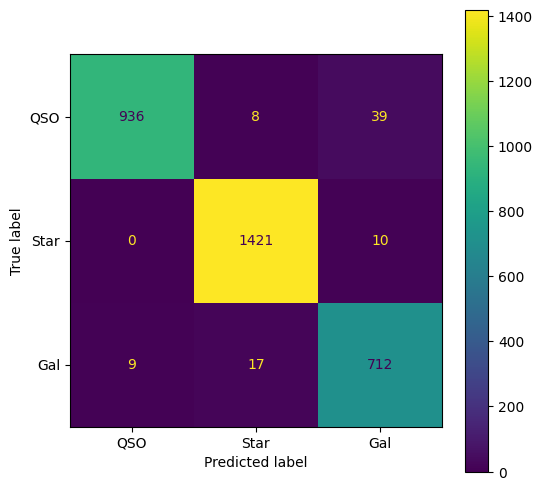

In [22]:
print("Confusion matrix PRF")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cm = confusion_matrix(cb_eval_y, prf_cb_eval_preds)
ls = ["QSO", "Star", "Gal"]  # your y labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot(ax=ax);

In [23]:
# We now need to check how many high redshift objects we missed
# PRF

cb_eval_hz_idx = np.where(cb_eval_z > 3.0)[0]
cb_eval_hz_qid = cb_eval_qid[cb_eval_hz_idx]
cb_eval_hz_z = cb_eval_z[cb_eval_hz_idx]
cb_eval_hz_known = cb_eval_y[cb_eval_hz_idx]

# PRF
prf_cb_eval_hz_idx_preds = prf_cb_eval_preds[cb_eval_hz_idx]


prf_missed_hz_qso_qso_star_gal = np.where(cb_eval_hz_known != prf_cb_eval_hz_idx_preds)[
    0
]

print("QID of hz QSO missed by PRF: ", cb_eval_hz_qid[prf_missed_hz_qso_qso_star_gal])
print(
    "Redshift of hz QSO missed by PRF: ", cb_eval_hz_z[prf_missed_hz_qso_qso_star_gal]
)

QID of hz QSO missed by PRF:  [15935995]
Redshift of hz QSO missed by PRF:  [3.86100006]


In [24]:
%%script echo Skipped
# SED of missed objects:
from IPython.display import Image, display

listOfImageNames = [
    "./data/SED_missed_QSO/SED_qid_1390813.png",
    "./data/SED_missed_QSO/SED_qid_903224.png",
    "./data/SED_missed_QSO/SED_qid_858331.png",
]

for imageName in listOfImageNames:
    display(Image(filename=imageName))

Skipped


In [25]:
%%script echo Skipped

# check against test set
extended_idx = np.where(otid == 8)[0]
all_star_idx = np.where(otid == 5)[0]

extended_dm = dm[extended_idx, :]
extended_de = de[extended_idx, :]
extended_flag = flag[extended_idx, :]

extended_qid = qid[extended_idx]
extended_ra = ra[extended_idx]
extended_dec = dec[extended_idx]
extended_otid = otid[extended_idx]
extended_z = z[extended_idx]

# Remove stars I have already used for training - as a matter of fact it might be worth to check also how many of those are included
c_chosen_star_idx = Counter(chosen_star_idx)
c_all_star_idx = Counter(all_star_idx)

star_not_used_training_idx = sorted((c_all_star_idx - c_chosen_star_idx).elements())

all_star_dm = dm[star_not_used_training_idx, :]
all_star_de = de[star_not_used_training_idx, :]
all_star_flag = flag[star_not_used_training_idx, :]

all_star_qid = qid[star_not_used_training_idx]
all_star_ra = ra[star_not_used_training_idx]
all_star_dec = dec[star_not_used_training_idx]
all_star_otid = otid[star_not_used_training_idx]
all_star_z = z[star_not_used_training_idx];

Skipped


In [26]:
%%script echo Skipped

# This also takes ages, so I will skip it for now
if run_again:
    # Check with prf
    prf_cb_compare = prf(**prf_params)
    prf_cb_compare.fit(X=cb_train_X, dX=cb_train_dX, y=cb_train_y, flags=cb_train_flag)

    print("Predictions on extended")
    prf_extended_preds = prf_cb_compare.predict(
        X=extended_dm, dX=extended_de, flags=extended_flag
    )

    print("Predictions on all star")
    prf_all_star_preds = prf_cb_compare.predict(
        X=all_star_dm, dX=all_star_de, flags=all_star_flag
    )

    print("PRF, extended as QSO: ", len(np.where(prf_extended_preds == 0)[0]))
    print("PRF, star as QSO: ", len(np.where(prf_all_star_preds == 0)[0]))

Skipped


In [27]:
if run_again:
    prf_for_test_qso_star_gal = prf(**prf_params)
    prf_for_test_qso_star_gal.fit(X=train_X, dX=train_dX, y=train_y, flags=train_flag)

    prf_test_preds = prf_for_test_qso_star_gal.predict(
        X=test_X, dX=test_dX, flags=test_flag
    )
    save_obj(prf_test_preds, "prf_test_preds_qso_star_gal")
else:
    prf_test_preds = load_obj("prf_test_preds_qso_star_gal")

200it [00:02, 95.53it/s]


Confusion matrix PRF - Test Dataset


(array([0.99047014, 0.97695473, 0.94555645]),
 array([0.95177045, 0.99580537, 0.95938262]),
 array([0.97073474, 0.98628999, 0.95241935]),
 array([1638, 2384, 1231]))

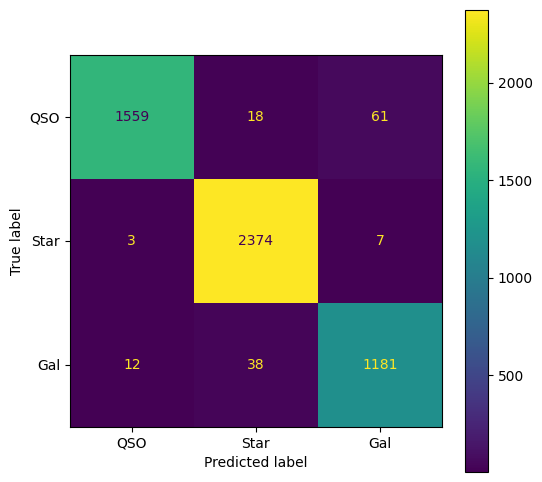

In [28]:
print("Confusion matrix PRF - Test Dataset")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cm = confusion_matrix(test_y, prf_test_preds)
ls = ["QSO", "Star", "Gal"]  # your y labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot(ax=ax)
precision_recall_fscore_support(test_y, prf_test_preds)

In [29]:
# Just need to make sure that all hz QSO have been found

test_hz_idx = np.where(test_z > 3.0)[0]
cb_test_hz_qid = test_qid[test_hz_idx]
cb_test_hz_z = test_z[test_hz_idx]

# PRF
prf_test_hz_preds = prf_test_preds[test_hz_idx]

prf_missed_hz_test_qso_qso_star_gal = np.where(
    test_y[test_hz_idx] != prf_test_hz_preds
)[0]

print(
    "QID of hz QSO missed by PRF: ",
    test_qid[test_hz_idx][prf_missed_hz_test_qso_qso_star_gal],
)
print(
    "Redshift of hz QSO missed by PRF: ",
    test_z[test_hz_idx][prf_missed_hz_test_qso_qso_star_gal],
)

# Super good! We find everything we are supposed to

QID of hz QSO missed by PRF:  []
Redshift of hz QSO missed by PRF:  []


In [30]:
# Finally, train algs on PRF and predict unks
unk_idx = np.where(otid == 0)[0]

unk_dm = dm[unk_idx, :]
unk_de = de[unk_idx, :]
unk_flag = flag[unk_idx, :]

unk_qid = qid[unk_idx]
unk_ra = ra[unk_idx]
unk_dec = dec[unk_idx]
unk_otid = otid[unk_idx]
unk_z = z[unk_idx]
print(f"Number of unknowns: {len(unk_idx)}")

Number of unknowns: 1836565


In [ ]:
if run_again:
    prf_unk = prf(**prf_params)
    prf_unk.fit(X=combined_X, dX=combined_dX, y=combined_y, flags=combined_flag)
    prf_unk_pred = prf_unk.predict(X=unk_dm, dX=unk_de, flags=unk_flag)

    prf_qso_cand_idx = np.where(prf_unk_pred == 0)[0]
    prf_qso_cand_qid = unk_qid[prf_qso_cand_idx]

    save_obj(prf_qso_cand_idx, "prf_qso_cand_idx_qso_star_gal")
    np.save(
        Path("/Users/francesco/uvp/PRF/data/cand")
        / ("PRF_id_QSO_All_redshift_" + timestamp + ".npy"),
        prf_qso_cand_qid,
    )
else:
    prf_qso_cand_idx = load_obj("prf_qso_cand_idx_qso_star_gal")

print(f"PRF: found {len(prf_qso_cand_idx)} QSO candidates.")

145it [12:31,  5.05s/it]

``` %load_ext line_profiler ```

#### **Now for the second part**
Here we need to figure out what is QSO with high redshift.  
The threshold is the same as the one I set above.

In [ ]:
# First thing first, let's produce everything required for QSO candidates, so that I can forget about it
prf_qso_candidates_X = unk_dm[prf_qso_cand_idx, :]
prf_qso_candidates_dX = unk_de[prf_qso_cand_idx, :]
prf_qso_candidates_flags = unk_flag[prf_qso_cand_idx, :]
prf_qso_candidates_qid = unk_qid[prf_qso_cand_idx]

In [ ]:
print("Current hz threshold: {}".format(QSO_redshift_threshold))

In [ ]:
# estimate redshift for candidates through XGBoost
import xgboost as xgb
from scipy import stats
from sklearn import model_selection as mod_sel

# ========================================================================== #
# ========================================================================== #
# ========================================================================== #

# only keep objects we are interested in and regenerate meta to be consistent
dm = np.load(basepath / "col_mag_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]
de = np.load(basepath / "col_err_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]
flag = np.load(basepath / "col_flag_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]
meta = np.load(basepath / "meta_2025-02-20_13:31:18.npy")[
    _inds_to_keep_from_beginning, :
]

qid = meta[:, 0].astype(int)
# using this, aka _id, instead of qid as in the new catalogue not every object has a qid
#  still calling it in the same way to avoid changing the rest of the code

# qid = meta[:, 1].astype(int) -> Useless for the new DB

ra = meta[:, 2]
dec = meta[:, 3]
otid = meta[:, 4].astype(int)  # Otypeid, from the DataBase
z = meta[:, 5]

# ========================================================================== #
# ========================================================================== #
# ========================================================================== #

# Find all QSOs
qso_idx = np.where(((otid == 1) | (otid == 2) | (otid == 3)))[0]
# Keep all kind of QSO into the sample
# Exclude low z QSO for now! They are dealt with below

qso_dm = dm[qso_idx, :]
qso_de = de[qso_idx, :]
qso_flag = flag[qso_idx, :]

qso_qid = qid[qso_idx]
qso_ra = ra[qso_idx]
qso_dec = dec[qso_idx]
qso_otid = otid[qso_idx]
qso_z = z[qso_idx]

# ========================================================================== #
# ========================================================================== #
# ========================================================================== #

# start with cross-validation
sss = mod_sel.ShuffleSplit(n_splits=10, test_size=0.1, random_state=rs)
reg_xgb = xgb.XGBRegressor(n_jobs=-1)

param_dist = {
    "eta": stats.uniform(0.0001, 0.3),
    "gamma": stats.uniform(0, 10),
    "alpha": stats.uniform(0, 10),
    "min_child_weight": stats.uniform(0, 10),
    "lambda": stats.uniform(0, 10),
    "max_depth": stats.randint(1, 10),
    "objective": [
        "reg:squarederror",
        "reg:squaredlogerror",
        "reg:absoluteerror",
    ],
    "n_estimators": stats.randint(1, 500),
    "subsample": stats.uniform(0.3, 0.6),
    "colsample_bytree": stats.uniform(0.5, 0.4),
}

reg = mod_sel.RandomizedSearchCV(
    reg_xgb,
    param_distributions=param_dist,
    cv=sss,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    error_score=0,
    verbose=2,
    random_state=rs,
)

df_input = qso_dm

weights = np.ones_like(qso_z)
weights[qso_z > 2.5] = 5

reg.fit(df_input, qso_z, sample_weight=weights)

bst_reg = reg.best_estimator_
bst_reg_params = reg.best_params_

# sanity check
all_qso_pred = bst_reg.predict(df_input)

preds_known_redshift = bst_reg.predict(df_input)
preds_cand_redshift = bst_reg.predict(prf_qso_candidates_X)

fig, ax = plt.subplots(layout="constrained")
plt.scatter(qso_z, preds_known_redshift - qso_z, alpha=0.2)
plt.show()

# there is no validation, which kind of annoys me but I just want to be quick
fig, ax = plt.subplots(layout="constrained")
plt.scatter(qso_z, preds_known_redshift, alpha=0.2)
plt.show()

cand_mlz_spec = preds_cand_redshift

```
qso_qid[np.abs(preds_known_redshift - qso_z) > 3], qso_ra[np.abs(preds_known_redshift - qso_z) > 3], qso_dec[np.abs(preds_known_redshift - qso_z) > 3]
```

In [ ]:
hz_qso_y = np.vectorize(get_y)(qso_z)
hz_splitting_y = np.vectorize(get_splitting_y, excluded=[1])(
    qso_z, [2.5, 3.0, 3.5, 4.0]
)

train_hz_X, test_hz_X = train_test_split(
    qso_dm, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_dX, test_hz_dX = train_test_split(
    qso_de, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_flag, test_hz_flag = train_test_split(
    qso_flag, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_y, test_hz_y = train_test_split(
    hz_qso_y, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_qid, test_hz_qid = train_test_split(
    qso_qid, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_ra, test_hz_ra = train_test_split(
    qso_ra, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_dec, test_hz_dec = train_test_split(
    qso_dec, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_otid, test_hz_otid = train_test_split(
    qso_otid, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_z, test_hz_z = train_test_split(
    qso_z, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)

train_hz_splitting_y, test_hz_splitting_y = train_test_split(
    hz_splitting_y, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)

hz_train_data = (train_hz_X, train_hz_dX, train_hz_y, train_hz_flag)

In [ ]:
# Score PRF

if run_again:
    qso_hz_cv, qso_hz_res_instances, qso_hz_prf_models = score_model(
        prf, prf_params, data=hz_train_data, sampling_strategy="auto"
    )
    save_obj(
        (qso_hz_cv, qso_hz_res_instances, qso_hz_prf_models),
        "PRF_LowHighQSO_cvInstance_TrainedPRF",
    )
else:
    qso_hz_cv, qso_hz_res_instances, qso_hz_prf_models = load_obj(
        "PRF_LowHighQSO_cvInstance_TrainedPRF"
    )

compute_metric_average(qso_hz_cv)

In [ ]:
compute_metric_average(qso_hz_cv)

In [ ]:
# From previous tests we roughly now what we are dealing with - things seem to work decently well
# We should also test what happens with different thresholds

# Regenerate training data with a different threshold
hz_qso_y = np.vectorize(get_y, excluded=["th"])(qso_z, th=3.0)
hz_splitting_y = np.vectorize(get_splitting_y, excluded=[1])(
    qso_z, [2.5, 3.0, 3.5, 4.0]
)

train_hz_X, test_hz_X = train_test_split(
    qso_dm, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_dX, test_hz_dX = train_test_split(
    qso_de, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_flag, test_hz_flag = train_test_split(
    qso_flag, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_y, test_hz_y = train_test_split(
    hz_qso_y, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_qid, test_hz_qid = train_test_split(
    qso_qid, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_ra, test_hz_ra = train_test_split(
    qso_ra, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_dec, test_hz_dec = train_test_split(
    qso_dec, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_otid, test_hz_otid = train_test_split(
    qso_otid, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)
train_hz_z, test_hz_z = train_test_split(
    qso_z, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)

train_hz_splitting_y, test_hz_splitting_y = train_test_split(
    hz_splitting_y, test_size=0.25, random_state=rs, stratify=hz_splitting_y
)

hz_train_data = (train_hz_X, train_hz_dX, train_hz_y, train_hz_flag)

In [ ]:
# Score PRF
# Does seem to work decently; not great, but decent
if run_again:
    qso_hz_cv, qso_hz_res_instances, qso_hz_prf_models = score_model(
        prf, prf_params, data=hz_train_data, sampling_strategy="auto"
    )
    save_obj(
        (qso_hz_cv, qso_hz_res_instances, qso_hz_prf_models),
        "PRF_LowHighQSO_th3_cvInstance_TrainedPRF",
    )
else:
    qso_hz_cv, qso_hz_res_instances, qso_hz_prf_models = load_obj(
        "PRF_LowHighQSO_th3_cvInstance_TrainedPRF"
    )

compute_metric_average(qso_hz_cv)

In [ ]:
# run everything again, with both thresholds
run_again = True

# Oversample
rs_os = 42
oversampler = RandomOverSampler(random_state=rs_os, sampling_strategy="auto")

final_train_data = [qso_dm, qso_de, np.vectorize(get_y)(qso_z), qso_flag]
data_names = ["X", "dX", "y", "flags"]
final_oversampled_train_data = {}

for name, val in zip(data_names, final_train_data):
    if len(val.shape) == 1:
        final_oversampled_train_data[name] = oversampler.fit_resample(
            val.reshape(-1, 1), np.vectorize(get_y)(qso_z)
        )[0]
    else:
        final_oversampled_train_data[name] = oversampler.fit_resample(
            val, np.vectorize(get_y)(qso_z)
        )[0]

# this time we run with 2.5, use everything for training
if run_again:
    prf_unk_hz = prf(**prf_params)
    prf_unk_hz.fit(**final_oversampled_train_data)
    prf_unk_pred_hz = prf_unk_hz.predict(
        X=prf_qso_candidates_X, dX=prf_qso_candidates_dX, flags=prf_qso_candidates_flags
    )

    prf_hz_qso_cand_idx = np.where(prf_unk_pred_hz == 1)[0]
    prf_hz_qso_cand_qid = prf_qso_candidates_qid[prf_hz_qso_cand_idx]
    prf_hz_qso_cand_mlz_spec = cand_mlz_spec[prf_hz_qso_cand_idx]

    save_obj(prf_hz_qso_cand_idx, "prf_hz_qso_cand_idx")
    np.save(
        Path("/Users/francesco/uvp/PRF/data/cand")
        / ("PRF_id_hzQSO_" + timestamp + ".npy"),
        np.vstack([prf_hz_qso_cand_qid, prf_hz_qso_cand_mlz_spec]).T,
    )
else:
    prf_qso_cand_idx = load_obj("prf_hz_qso_cand_idx")

print("PRF: found {} hz QSO candidates.".format(len(prf_hz_qso_cand_idx)))


#  ---------------------------------------------------------------------------- #


# Oversample again, with different  threshold
final_train_data = [qso_dm, qso_de, np.vectorize(get_y)(qso_z, th=3), qso_flag]
data_names = ["X", "dX", "y", "flags"]
final_oversampled_train_data = {}

for name, val in zip(data_names, final_train_data):
    if len(val.shape) == 1:
        final_oversampled_train_data[name] = oversampler.fit_resample(
            val.reshape(-1, 1), np.vectorize(get_y)(qso_z, th=3)
        )[0]
    else:
        final_oversampled_train_data[name] = oversampler.fit_resample(
            val, np.vectorize(get_y)(qso_z, th=3)
        )[0]

# This time with z = 3
if run_again:
    prf_unk_hz = prf(**prf_params)
    prf_unk_hz.fit(**final_oversampled_train_data)
    prf_unk_pred_hz = prf_unk_hz.predict(
        X=prf_qso_candidates_X, dX=prf_qso_candidates_dX, flags=prf_qso_candidates_flags
    )

    prf_hz_qso_cand_idx = np.where(prf_unk_pred_hz == 1)[0]
    prf_hz_qso_cand_qid = prf_qso_candidates_qid[prf_hz_qso_cand_idx]
    prf_hz_qso_cand_mlz_spec = cand_mlz_spec[prf_hz_qso_cand_idx]

    save_obj(prf_hz_qso_cand_idx, "prf_hz_qso_cand_idx_z3")
    np.save(
        Path("/Users/francesco/uvp/PRF/data/cand")
        / ("PRF_id_hzQSO_z3_" + timestamp + ".npy"),
        np.vstack([prf_hz_qso_cand_qid, prf_hz_qso_cand_mlz_spec]).T,
    )
else:
    prf_qso_cand_idx = load_obj("prf_hz_qso_cand_idx_z3")

print("PRF: found {} hz QSO candidates (th: z = 3).".format(len(prf_hz_qso_cand_idx)))


#  ---------------------------------------------------------------------------- #

# rememver to always write these with the ., also for integers
#  e.g. 3.0, not 3
current_high_z_th = 4.75

# Oversample again, with different  threshold
final_train_data = [
    qso_dm,
    qso_de,
    np.vectorize(get_y)(qso_z, th=current_high_z_th),
    qso_flag,
]
data_names = ["X", "dX", "y", "flags"]
final_oversampled_train_data = {}

for name, val in zip(data_names, final_train_data):
    if len(val.shape) == 1:
        final_oversampled_train_data[name] = oversampler.fit_resample(
            val.reshape(-1, 1), np.vectorize(get_y)(qso_z, th=current_high_z_th)
        )[0]
    else:
        final_oversampled_train_data[name] = oversampler.fit_resample(
            val, np.vectorize(get_y)(qso_z, th=current_high_z_th)
        )[0]

# This time with z = current_high_z_th
if run_again:
    prf_unk_hz = prf(**prf_params)
    prf_unk_hz.fit(**final_oversampled_train_data)
    prf_unk_pred_hz = prf_unk_hz.predict(
        X=prf_qso_candidates_X, dX=prf_qso_candidates_dX, flags=prf_qso_candidates_flags
    )

    prf_hz_qso_cand_idx = np.where(prf_unk_pred_hz == 1)[0]
    prf_hz_qso_cand_qid = prf_qso_candidates_qid[prf_hz_qso_cand_idx]
    prf_hz_qso_cand_mlz_spec = cand_mlz_spec[prf_hz_qso_cand_idx]

    save_obj(
        prf_hz_qso_cand_idx,
        f"prf_hz_qso_cand_idx_z{str(current_high_z_th).replace('.', 'p')}",
    )
    np.save(
        Path("/Users/francesco/uvp/PRF/data/cand")
        / (
            f"PRF_id_hzQSO_z{str(current_high_z_th).replace('.', 'p')}_"
            + timestamp
            + ".npy"
        ),
        np.vstack([prf_hz_qso_cand_qid, prf_hz_qso_cand_mlz_spec]).T,
    )
else:
    prf_qso_cand_idx = load_obj(
        f"prf_hz_qso_cand_idx_z{str(current_high_z_th).replace('.', 'p')}"
    )

print(
    f"PRF: found {len(prf_hz_qso_cand_idx)} hz QSO candidates (th: z = {current_high_z_th})."
)

```
4.50 -> 107558419, 1022742188, 2180144754
4.75 -> 22578982,  107558419, 2020539113, 2029433156, 2040195311, 2703137155
```

```
for _id in [1022742188, 2180144754, 22578982, 107558419, 2020539113, 2029433156, 2040195311, 2703137155]
    println(ms[!, ["_id", "raj2000", "decj2000",  "u_psf", "v_psf", "g_psf", "r_psf", "i_psf", "z_psf", "phot_g_mean_mag", "phot_rp_mean_mag", "phot_bp_mean_mag"]])
end

tmp = DataFrame(_id = [1022742188, 2180144754, 22578982, 107558419, 2020539113, 2029433156, 2040195311, 2703137155])
tmp = innerjoin(tmp, ms, on = :_id)
tmp[!, "_id", "raj2000", "decj2000",  "u_psf", "v_psf", "g_psf", "r_psf", "i_psf", "z_psf", "phot_g_mean_mag", "phot_rp_mean_mag", "phot_bp_mean_mag"]

```